# Text or No Text Classification - Level 1


## Task Details


The Level 1 task contains 1189 total images(train + test) with below details:

| No. of -ve images(train + test) | No. of +ve images(train + test) | Image dimensions | -ve image characterstics                                               | +ve image characterstics                                                                                                                                                                    |
| ------------------------------- | ------------------------------- | ---------------- | ---------------------------------------------------------------------- | ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------- |
| 595 (447 + 148)                 | 594 (445 + 149)                 | 16x16            | White background ![](../assets/text_no-text_level1_no-text_sample.jpg) | Character over white background ![](../assets/text_no-text_level1_text_sample1.jpg) ![](../assets/text_no-text_level1_text_sample2.jpg) ![](../assets/text_no-text_level1_text_sample3.jpg) |


Sigmoid Neuron Model:

$\LARGE \hat{y} = \frac {1} {1 + e^{-(w \cdot x + b)}}$

<br/>

Cross Entropy Loss:

$\large L(\theta) = -\sum_{i=1}^m {( (1-y_i) \log{(1 - \hat{y_i})} + y_i \log \hat{y_i})}$

$\text{where, m = no. of training examples}$


## Import Library


In [1]:
import os, shutil, sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from zipfile import ZipFile
from tqdm import tqdm, trange
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss, accuracy_score

sys.path.insert(0, '..')

from packages.utils import plot_images

np.random.seed(0)
warnings.filterwarnings("ignore")

## Configurations


In [2]:
CONFIG = {
    "DATASET_FILE_PATH" : "../data/Text_No-Text_Level1.zip",
    "DATASET_FOLDER" : "../downloads/Text_No-Text_Level1/",
    "IMAGE_SIZE": (16, 16),
    "THRESHOLD": 0.7
}
CONFIG["TRAIN_FOLDER"] = f'{CONFIG["DATASET_FOLDER"]}train/'
CONFIG["TEST_FOLDER"] = f'{CONFIG["DATASET_FOLDER"]}test/'

## Load Data


In [3]:
# Unzipping data
try:
    with ZipFile(CONFIG["DATASET_FILE_PATH"]) as file:
        file.extractall(CONFIG["DATASET_FOLDER"])
except:
    print('Error while unzipping the file')

In [4]:
def read_all(folder_path, key_prefix=""):
    print("Reading:")
    images = {}
    files = os.listdir(folder_path)
    for i, file_name in tqdm(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        image = image.convert("L")
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [5]:
languages = ['ta', 'hi', 'en']

images_train = read_all(f'{CONFIG["TRAIN_FOLDER"]}background/', key_prefix='bgr_') # change the path
for language in languages:
  images_train.update(read_all(CONFIG["TRAIN_FOLDER"] + language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all(CONFIG["TEST_FOLDER"], key_prefix='') # change the path
print(len(images_test))

list(images_test.keys())[:5]

X = []
Y = []
for key, value in images_train.items():
    X.append(value)
    if key[:4] == "bgr_":
        Y.append(0)
    else:
        Y.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
  ID_test.append(int(key))
  X_test.append(value)
  
        
X = np.array(X)
Y = np.array(Y)
X_test = np.array(X_test)

print(X.shape, Y.shape)
print(X_test.shape)

Reading:


100%|██████████| 447/447 [00:00<00:00, 1264.59it/s]


Reading:


100%|██████████| 146/146 [00:00<00:00, 2106.89it/s]


Reading:


100%|██████████| 149/149 [00:00<00:00, 1778.79it/s]


Reading:


100%|██████████| 150/150 [00:00<00:00, 1257.13it/s]


892
Reading:


100%|██████████| 297/297 [00:00<00:00, 1220.03it/s]

297
(892, 256) (892,)
(297, 256)


In [6]:
df = pd.read_csv('../downloads/Text_No-Text_Level1/test_data_labels.csv')
Y_test = []

for key in ID_test:
    Y_test.append(df[df['file_name'] == f'{key}.jpg']['class'].item())

Y_test = np.array(Y_test)

In [7]:
print(X.shape, Y.shape, X_test.shape, Y_test.shape)

(892, 256) (892,) (297, 256) (297,)


## Visualize the data


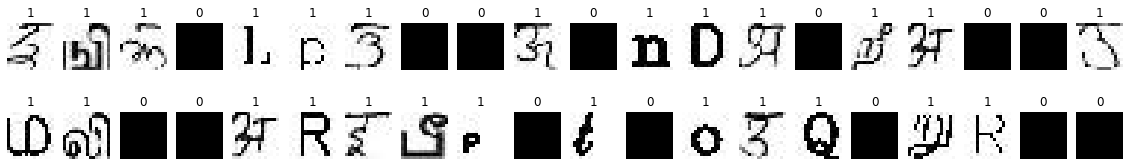

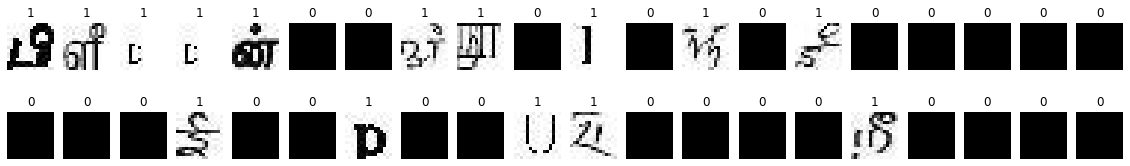

In [8]:
indexs = np.random.randint(1, X.shape[0], size=40)
plot_images(X[indexs], Y[indexs], image_size=CONFIG["IMAGE_SIZE"], columns=20, figsize=(20, 3))

indexs = np.random.randint(1, X_test.shape[0], size=40)
plot_images(X_test[indexs], Y_test[indexs], image_size=CONFIG["IMAGE_SIZE"], columns=20, figsize=(20, 3))

## Train-Test Split


In [9]:
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.15, random_state=10, stratify=Y, shuffle=True)

print(X_train.shape, Y_train.shape, X_val.shape, Y_val.shape)

(758, 256) (758,) (134, 256) (134,)


In [10]:
print(Y.mean(), Y_train.mean(), Y_val.mean(), Y_test.mean())

0.49887892376681614 0.49868073878627966 0.5 0.5016835016835017


## Normalize data


In [11]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

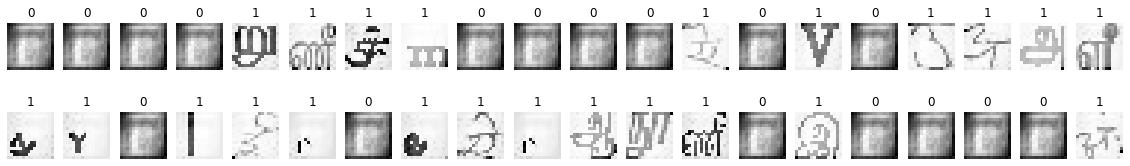

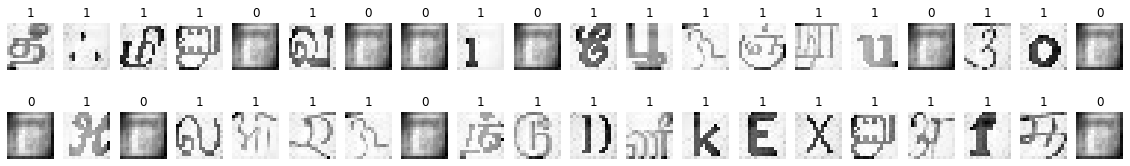

In [12]:
indexs = np.random.randint(1, X_train.shape[0], size=40)
plot_images(X_train[indexs], Y_train[indexs], image_size=CONFIG["IMAGE_SIZE"], columns=20, figsize=(20, 3))

indexs = np.random.randint(1, X_test.shape[0], size=40)
plot_images(X_test[indexs], Y_test[indexs], image_size=CONFIG["IMAGE_SIZE"], columns=20, figsize=(20, 3))

## Model Class


In [13]:
class SigmoidNeuron:
    def __init__(self):
        self.w = None
        self.b = None
        self.train_loss = []
        self.train_accuracy = []
        self.val_loss = []
        self.val_accuracy = []

    def model(self, x):
        return 1. / (1. + np.exp(- (np.dot(self.w, x) + self.b)))

    def predict(self, X):
        return np.asarray([self.model(x) for x in X])

    def loss(self, Y, Y_pred):
        return log_loss(Y, Y_pred)

    def accuracy(self, Y, Y_pred):
        return accuracy_score(Y, (Y_pred >= CONFIG["THRESHOLD"]).astype(int))

    def grad_w(self, x, y, y_pred):
        return (y_pred - y) * x

    def grad_b(self, y, y_pred):
        return y_pred - y

    def fit(self, X_train, Y_train, X_val, Y_val, epochs=1, learning_rate=1, initialise=True):
        if initialise:
            self.w = np.random.randn(1, X_train.shape[1])
            self.b = 0

        for _ in trange(epochs, unit='epoch', desc='Epoch'):
            Y_pred = self.predict(X_train)

            dw = 0
            db = 0
            for x, y, y_pred in zip(X_train, Y_train, Y_pred):
                dw += self.grad_w(x, y, y_pred)
                db += self.grad_b(y, y_pred)

            self.w -= (learning_rate * dw)
            self.b -= (learning_rate * db)

            Y_pred = self.predict(X_train)
            self.train_loss.append(self.loss(Y_train, Y_pred))
            self.train_accuracy.append(self.accuracy(Y_train, Y_pred))

            Y_val_pred = self.predict(X_val)
            self.val_loss.append(self.loss(Y_val, Y_val_pred))
            self.val_accuracy.append(self.accuracy(Y_val, Y_val_pred))

        print('Final Train Loss:', self.train_loss[-1])
        print('Final Validation Loss:', self.val_loss[-1])
        print('Final Train Accuracy:', self.train_accuracy[-1])
        print('Final Validation Accuracy:', self.val_accuracy[-1])

    def plot_graphs(self):
        plt.plot(self.train_loss, label='Train Loss')
        plt.plot(self.val_loss, label='Test Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Log Loss Error')
        plt.legend()
        plt.show()

        plt.plot(self.train_accuracy, label='Train Accuracy')
        plt.plot(self.val_accuracy, label='Test Accuracy')
        plt.xlabel('Epochs')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

    def evalute(self, X_test, Y_test):
        Y_test_pred = self.predict(X_test)
        print('Test Accuracy:', self.accuracy(Y_test, Y_test_pred))

## Train Model


Epoch: 100%|██████████| 100/100 [00:04<00:00, 22.66epoch/s]


Final Train Loss: 2.3007858682366594e-05
Final Validation Loss: 0.16280315595965134
Final Train Accuracy: 1.0
Final Validation Accuracy: 0.9925373134328358


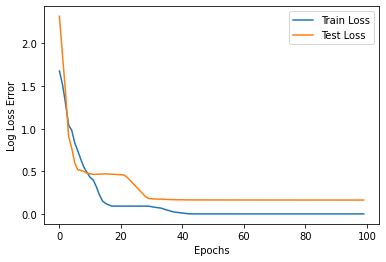

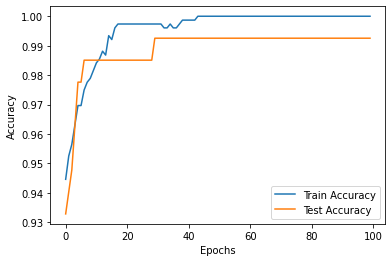

In [14]:
model = SigmoidNeuron()
model.fit(X_train, Y_train, X_val, Y_val, epochs=100, learning_rate=0.05)
model.plot_graphs()

## Evaluate Model


In [15]:
model.evalute(X_test, Y_test)

Test Accuracy: 0.9865319865319865


## Clean Repository


In [16]:
shutil.rmtree(CONFIG["DATASET_FOLDER"], ignore_errors=True)